In [1]:
import pandas as pd
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 30)
pd.set_option('display.float_format', '{:.2f}'.format)
df = pd.read_csv('data1.txt', encoding='windows-1251')

In [3]:
df.head()

,DR_Dat,DR_Tim,DR_NChk,DR_NDoc,DR_Apt,DR_Kkm,DR_TDoc,DR_TPay,DR_CDrugs,DR_NDrugs,DR_Suppl,DR_Prod,DR_Kol,DR_CZak,DR_CRoz,DR_SDisc,DR_CDisc,DR_BCDisc,DR_TabEmpl,DR_VZak,DR_Pos
0,2022-08-01,08:06:18,1272,13002561,13,22589,Розничная реализация,18,144734,ГАСТАЛ №12 ТАБ. Д/РАСС.,Пульс,TEVA Pharvaceutical Industries Ltd,1.00,196.71,270.00,0.00,NaN,NaN,29,1,1.00
1,2022-08-01,08:38:53,1273,13002561,13,22589,Розничная реализация,15,69661,"ТОБРОПТ 0,3% 5МЛ. №1 ГЛ.КАПЛИ ФЛ./КАП. /РОМФАРМ/",Пульс,РОМФАРМ КОМПАНИ ( ROMPHARM ),1.00,106.21,127.00,6.00,9.00,200010004357.00,29,1,1.00
2,2022-08-01,08:55:38,1274,13002561,13,22589,Розничная реализация,18,190635,ЭЛИКВИС 5МГ. №60 ТАБ. П/П/О /ПФАЙЗЕР/БРИСТОЛ-М...,ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК,Пфайзер,1.00,2320.99,2563.00,76.00,9.00,200010018491.00,29,1,1.00
3,2022-08-01,09:00:40,1275,13002561,13,22589,Розничная реализация,18,276370,АРБИДОЛ МАКСИМУМ 200МГ. №10 КАПС. /ОТИСИФАРМ/Ф...,Пульс,ОТИСИФАРМ ПАО,1.00,445.39,541.00,0.00,NaN,NaN,29,1,1.00
4,2022-08-01,09:04:05,1276,13002561,13,22589,Розничная реализация,15,2303,"ЭНАМ 2,5МГ. №20 ТАБ. /Д-Р РЕДДИ/",Протек,Д-р Редди с Лабораторис Лтд / Dr.REDDY's,1.00,18.04,22.00,1.00,9.00,200010000734.00,29,1,5.00


In [4]:
# to see daily trend i need to group my data by date column
# i also need to take into account the discount
df.groupby('DR_Dat').apply(lambda x: sum(x['DR_Kol'] * x['DR_CRoz'] - x['DR_SDisc']), include_groups=False)
# or
df.groupby('DR_Dat')[['DR_Kol', 'DR_CRoz', 'DR_SDisc']].apply(lambda x: sum(x['DR_Kol'] * x['DR_CRoz'] - x['DR_SDisc']))

DR_Dat
2022-08-01   84681.52
2022-08-02   71389.37
2022-08-03   78050.82
2022-08-04   59187.36
2022-08-05   56458.81
dtype: float64

In [5]:
df_daily_revenue = df.groupby('DR_Dat').apply(lambda x: pd.Series({'d_rev': sum(x['DR_Kol'] * x['DR_CRoz'] - x['DR_SDisc']) }), include_groups=False).reset_index()
df_daily_revenue

,DR_Dat,d_rev
0,2022-08-01,84681.52
1,2022-08-02,71389.37
2,2022-08-03,78050.82
3,2022-08-04,59187.36
4,2022-08-05,56458.81


In [6]:
# here is first option of calculating daily diff by using 'rolling()' function
# arg 'window' tells how many rows will be affected by function - in my case two - current and next after it
df_daily_revenue['d_rev'].rolling(window=2).sum()

0         NaN
1   156070.89
2   149440.19
3   137238.18
4   115646.17
Name: d_rev, dtype: float64

In [7]:
# this is how i can calculate diff in %
df_daily_revenue['st_1'] = df_daily_revenue['d_rev'].rolling(2).apply(lambda x: (x.iloc[1] - x.iloc[0])/x.iloc[0])
df_daily_revenue = df_daily_revenue.fillna(0)
df_daily_revenue

,DR_Dat,d_rev,st_1
0,2022-08-01,84681.52,0.00
1,2022-08-02,71389.37,-0.16
2,2022-08-03,78050.82,0.09
3,2022-08-04,59187.36,-0.24
4,2022-08-05,56458.81,-0.05


In [8]:
# second option is to use 'shift()' function 
# i need to add new column with shifted values and calculate diff between them
df_daily_revenue['d_rev_shft'] = df_daily_revenue['d_rev'].shift(1)
df_daily_revenue['st_2'] = (df_daily_revenue['d_rev'] - df_daily_revenue['d_rev_shft']) / df_daily_revenue['d_rev_shft']
df_daily_revenue = df_daily_revenue.fillna(0)
df_daily_revenue

,DR_Dat,d_rev,st_1,d_rev_shft,st_2
0,2022-08-01,84681.52,0.00,0.00,0.00
1,2022-08-02,71389.37,-0.16,84681.52,-0.16
2,2022-08-03,78050.82,0.09,71389.37,0.09
3,2022-08-04,59187.36,-0.24,78050.82,-0.24
4,2022-08-05,56458.81,-0.05,59187.36,-0.05


In [9]:
# and third option is tu use 'pct_change()' function
df_daily_revenue['st_3'] = df_daily_revenue['d_rev'].pct_change(1).fillna(0)
# 1 stands for closest value to calculate diff
df_daily_revenue

,DR_Dat,d_rev,st_1,d_rev_shft,st_2,st_3
0,2022-08-01,84681.52,0.00,0.00,0.00,0.00
1,2022-08-02,71389.37,-0.16,84681.52,-0.16,-0.16
2,2022-08-03,78050.82,0.09,71389.37,0.09,0.09
3,2022-08-04,59187.36,-0.24,78050.82,-0.24,-0.24
4,2022-08-05,56458.81,-0.05,59187.36,-0.05,-0.05


<Axes: xlabel='DR_Dat', ylabel='d_rev'>

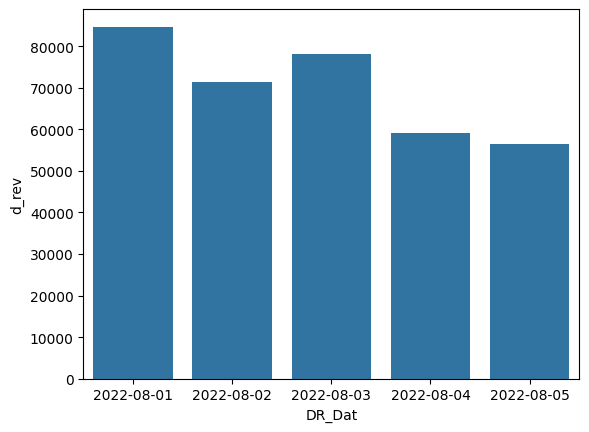

In [12]:
sns.barplot(data=df_daily_revenue, x='DR_Dat', y='d_rev')